# Estimating ECM Parameters & Running a Thermal Submodel

This notebook provides example usage for estimating stationary parameters for a two RC branch Thevenin model. With the estimated parameters, a thermal model is created and predictions are made.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [1]:
%pip install --upgrade pip ipywidgets openpyxl pandas -q
%pip install pybop -q

import pandas as pd
import pybamm

import pybop

pybop.PlotlyManager().pio.renderers.default = "notebook_connected"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In this example, we use the default parameter value for the `"Open-circuit voltage [V]"` as provided by the original PyBaMM class. To update this, provide a function definition that matches this [function](https://github.com/pybamm-team/PyBaMM/blob/1943aa5ab2895b5378220595923dbae3d66b13c9/pybamm/input/parameters/ecm/example_set.py#L17). First, we load and update the ECM input parameters,

In [2]:
parameter_set = pybop.ParameterSet.pybamm("ECM_Example")
parameter_set.update(
    {
        "Cell capacity [A.h]": 3,
        "Nominal cell capacity [A.h]": 3,
        "Element-1 initial overpotential [V]": 0,
        "Upper voltage cut-off [V]": 4.2,
        "Lower voltage cut-off [V]": 2.5,
        "R0 [Ohm]": 1e-3,
        "R1 [Ohm]": 3e-3,
        "C1 [F]": 5e2,
        "Open-circuit voltage [V]": pybop.empirical.Thevenin().default_parameter_values[
            "Open-circuit voltage [V]"
        ],
    }
)
# Optional arguments - only needed for two RC pairs
parameter_set.update(
    {
        "R2 [Ohm]": 0.002,
        "C2 [F]": 3e4,
        "Element-2 initial overpotential [V]": 0,
    },
    check_already_exists=False,
)

Now that the initial parameter set is constructed, we can start the PyBOP fitting process. First, we define the model class with two RC elements.

In [3]:
model = pybop.empirical.Thevenin(
    parameter_set=parameter_set,
    options={"number of rc elements": 2},
    solver=pybamm.CasadiSolver(mode="safe", dt_max=10),
)

Next we need to select the data for parameter identification. In this example we use a single HPPC pulse from the   
`Kollmeyer, Phillip; Skells, Michael (2020), “Samsung INR21700 30T 3Ah Li-ion Battery Data”, Mendeley Data, V1, doi: 10.17632/9xyvy2njj3.1` dataset. This is imported and used to construct the `pybop.Dataset` class,

In [4]:
file_loc = r"../data/Samsung_INR21700/sample_hppc_pulse.xlsx"
df = pd.read_excel(file_loc, index_col=None, na_values=["NA"])
df = df.drop_duplicates(subset=["Time"], keep="first")

dataset = pybop.Dataset(
    {
        "Time [s]": df["Time"].to_numpy(),
        "Current function [A]": df["Current"].to_numpy(),
        "Voltage [V]": df["Voltage"].to_numpy(),
    }
)

Next, we need to define the parameter for identification. In this example, we've construct a two-branch Thevenin model, so we will select those parameters for identification. The initial guess for the resistance parameter is generated from a random sample of the prior distributions. These are influenced by the `r_guess` parameter below.

In [5]:
r_guess = 0.005
parameters = pybop.Parameters(
    pybop.Parameter(
        "R0 [Ohm]",
        prior=pybop.Gaussian(r_guess, r_guess / 10),
        bounds=[0, 0.2],
    ),
    pybop.Parameter(
        "R1 [Ohm]",
        prior=pybop.Gaussian(r_guess, r_guess / 10),
        bounds=[0, 0.2],
    ),
    pybop.Parameter(
        "R2 [Ohm]",
        prior=pybop.Gaussian(r_guess, r_guess / 10),
        bounds=[0, 0.2],
    ),
    pybop.Parameter(
        "C1 [F]",
        prior=pybop.Gaussian(500, 100),
        bounds=[100, 10000],
    ),
    pybop.Parameter(
        "C2 [F]",
        prior=pybop.Gaussian(2000, 500),
        bounds=[100, 10000],
    ),
)

The `FittingProblem` class provides us with a single class that holds the objects we need to evaluate our selected `SumSquaredError` cost function. As we haven't built the model, we first do that with an initial OCV state selected from the first data point in the HPPC pulse.

In [6]:
model.build(
    initial_state={"Initial open-circuit voltage [V]": df["Voltage"].to_numpy()[0]}
)
problem = pybop.FittingProblem(
    model,
    parameters,
    dataset,
)

cost = pybop.SumSquaredError(problem)

Next, we construct the optimisation class with our algorithm of choice and run it. In this case, we select the XNES method as it provides global optimisation capability. For the sake of reducing the runtime of this example, we limit the maximum iterations to 100; however, feel free to update this value. Due to the scale differences in the parameters, we update the optimiser step-size (`sigma0`) to be parameter specific, which helps ensure the optimiser explores the complete parameter space.

In [7]:
optim = pybop.XNES(
    cost,
    sigma0=[1e-3, 1e-3, 1e-3, 20, 20],
    max_unchanged_iterations=30,
    max_iterations=100,
)
x, final_cost = optim.run()
print("Initial parameters:", optim.x0)
print("Estimated parameters:", x)

Initial parameters: [5.23889280e-03 5.86558394e-03 5.08906401e-03 5.21844050e+02
 2.64240978e+03]
Estimated parameters: [1.05127792e-02 4.34063511e-03 3.57417951e-02 5.96113674e+02
 2.14915067e+03]


## Plotting and Visualisation

Next, we use PyBOP's plotting utilities to visualise the results of the optimisation. This provides us with a visual confirmation of the optimisers' converged parameter values in the time-domain output.

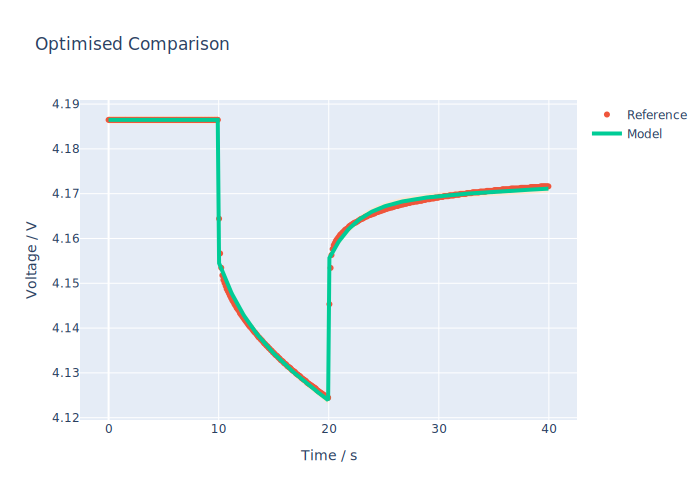

In [8]:
pybop.quick_plot(problem, problem_inputs=x, title="Optimised Comparison");

## Convergence and Parameter Trajectories

To assess the optimisation process, we can plot the convergence of the cost function and the trajectories of the parameters:

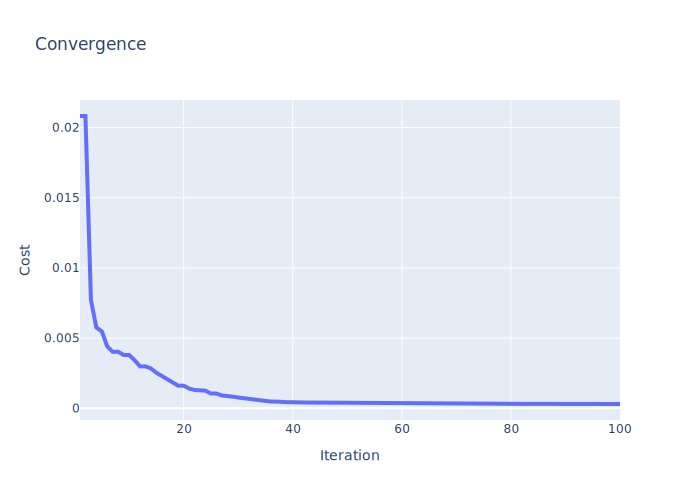

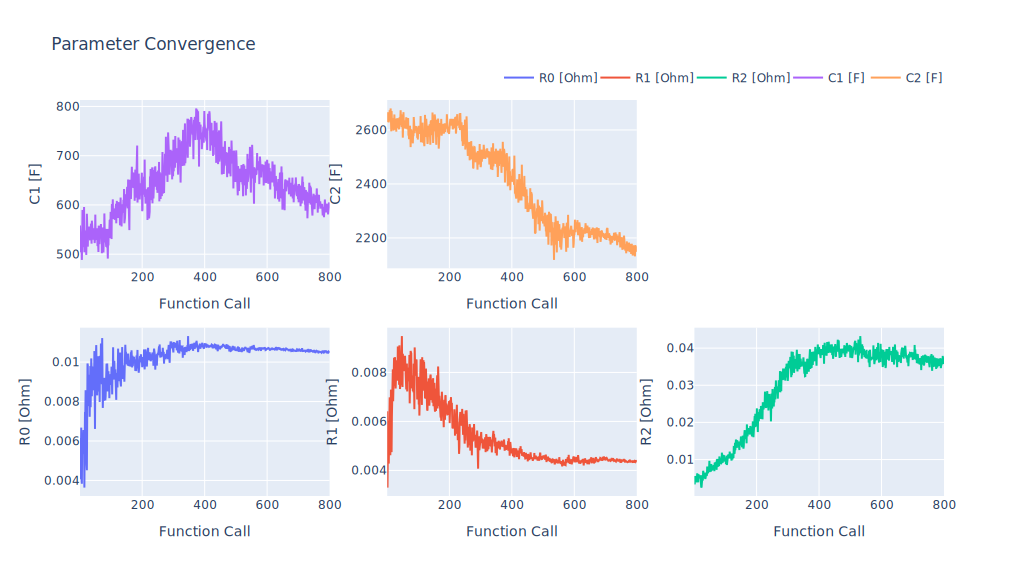

In [9]:
pybop.plot_convergence(optim)
pybop.plot_parameters(optim);

## Using the estimated parameter for thermal predictions
With the estimated RC parameters, the temperature distribution for a given drive cycle can be calculated using the identified Thevenin model. We now we use a `.xlsx` file containing time-series current data as a pybamm experiment. A sample file is used here, but user's may choose to upload customized drive cycle.

In [10]:
file_loc = r"../data/Samsung_INR21700/sample_drive_cycle.xlsx"
df = pd.read_excel(file_loc, sheet_name="Sheet3", index_col=None, na_values=["NA"])

# Remove duplicate rows, keeping the first occurrence
df = df.drop_duplicates(subset=["Time"], keep="first")

# Create the pybamm experiment
experiment = pybamm.Experiment([pybamm.step.current(df.to_numpy())])

Update the estimated RC values. These values will be used to calculate heat generation and corresponding temperature distribution in the thermal submodel. Given `model.predict` is a light wrapper on the `PyBaMM.Simulation` class, we interact with it the same way. Visualisation of voltage response and cell temperature is plotted below using the PyBaMM solution.

In [11]:
sol = model.predict(
    inputs=x,
    experiment=experiment,
    parameter_set=parameter_set,
    initial_state={"Initial SoC": 0.95},
)
sol.plot(["Battery voltage [V]", "Cell temperature [K]"])

2024-09-17 11:50:30.764 - [WARNING] callbacks.on_experiment_infeasible_time(240): 

	Experiment is infeasible: default duration (3600 seconds) was reached during 'Step([[   0    3]
 [   1    3]
 [   2    3]
 ...
 [3598    3]
 [3599    3]
 [3600    3]], duration=3600, period=1, direction=Discharge)'. The returned solution only contains up to step 1 of cycle 1. Please specify a duration in the step instructions.


interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

## Conclusion

This notebook illustrates how to extract EC parameters from an HPPC pulse using XNES in PyBOP, providing insights into the optimisation process through various visualisations. The estimated parameters are then used to run a thermal submodel.